# Introduction

這份文件基於論文[Attractor Network Models](https://nyuscholars.nyu.edu/en/publications/attractor-network-models)中的範例 -- ***神經細胞是一個動態系統(The Neuron Is a Dynamical System)***，以Julia code實現，並加以說明其中的細節，希望藉此讓大家更了解吸引子(attractor)在其中扮演的角色。


# Julia Packages

+ [Calculus.jl](https://github.com/JuliaMath/Calculus.jl) (用於數值微分)
+ [QuadGk.jl](https://github.com/JuliaMath/QuadGK.jl) (用於數值積分)
+ [Roots.jl](https://github.com/JuliaMath/Roots.jl) (用於尋找方程式解)
+ [Plots.jl](https://github.com/JuliaPlots/Plots.jl) (用於繪製圖表)

In [1]:
using Calculus, QuadGK, Roots
using Plots

# Models

透過微分方程和適當的參數，我們可以簡單模擬神經細胞的膜電位變化。

$$ C_{m} \frac{dV_{m}}{dt} = \color{blue}{-g_{L}(V_{m} - E_{L})} \color{Red}{- g_{NaP} \cdot m_{NaP}(V_{m}) \cdot (V_{m} - E_{Na})} + I_{app} \ \ \ \ \ \ \ \ [1]$$
$$ m_{NaP}(V_{m}) = \frac{1}{1 + e^{\frac{-(V_{m}+45)}{5}}} \ \ \ \ \ \ \ \ [2]$$

$$(C_{m}\ \mathrm{(nF)},\ \ V_{m}\ \mathrm{(mV)},\ \ g_{L}\ \mathrm{(\mu S)},\ \ E_{L}\ \mathrm{(mV)},\ \ I_{app}\ \mathrm{(nA)})$$

式$[1]$描述了膜電位$(V_{m})$會如何隨時間變化，若等式右邊為正，那麼膜電位將持續增加，反之，若等式右邊為負，則膜電位逐漸減小。  
而當$\frac{dV_{m}}{dt}=0$則代表膜電位維持穩定，不再變化。  
<br>
<br>
先讓我們看每一項代表的意義，後續會再逐項介紹：
+ $I_{app}$是指外加在這顆神經細胞上的電流，這裡暫時先不考慮，設 $I_{app}=0$。
+ $\color{blue}{-g_{L}(V_{m} - E_{L})}$ 代表在細胞膜上存在常開的離子通道，離子通過其中產生的電流，作用是穩定膜電位。  
+ $\color{Red}{- g_{NaP} \cdot m_{NaP}(V_{m}) \cdot (V_{m} - E_{Na})}$ 代表電壓控制型鈉離子通道，鈉離子流過而產生的電流，只有當膜電位去極化至一定程度，通道才會逐漸開啟。

首先，我們先定義好會使用到的參數和函式，一樣會在後文介紹參數所代表的含意。  
(注意：雖然在公式中有列出$C_{m}$，但以下在定義函式時為求簡化，會省略之，同時也是為了重現論文中的結果。)

In [2]:
# 定義參數
Cm = 0.5
gL = 0.025
EL = -70
ENa = 55
gNaP = 0.0
Iapp = 0.0

# 定義函式
mNaP(Vm) = 1 / (1 + ℯ^(-(Vm+45) / 5))
dV(Vm) = (-gL * (Vm - EL)) - (gNaP * mNaP(Vm) * (Vm - ENa)) + Iapp

# 選用一個膜電位範圍作為計算的區域，這裡根據論文取用 -100 ~ 0，間隔為 1，產生結果會類似 [-100 -99 -98 ... -2 -1 0] 這樣一個向量
V = -100:1:0

-100:1:0

### Leaky Current : $\color{blue}{-g_{L}(V_{m} - E_{L})}$
代表神經細胞膜上存在著常開的離子通道，當膜電位不在靜止電位上，就會有離子流入/流出(稱作leaky current)，以維持平衡。
+ $E_{L}$ 指靜止電位(resting potential)，多為 -50 ~ -70(mV)，因細胞膜內外各種離子濃度不一導致。
+ $g_{L}$ 指電導(conductance)，可以簡單想像成，當電導值越大，就相當於通道越多。因此在相同$C_{m}$的情況下，電導值越大，膜電位回到平衡時所需時間就越快。
+ $C_{m}$ 指電容(capacitance)，因細胞膜的構造為磷脂雙層(phospholipid bilayer)，具有不導電的特性導致。膜電位變化速率之時間常數由$C_{m}$和$g_{L}$共同決定$(\tau_{m} = \frac{C_{m}}{g_{L}})$。

因我們直接設定參數$E_{L}=-70$，所以可從下圖看出膜電位平衡位置就在-70mV。  
舉個例子，假設現在膜電位處於-60mV，此時就會有離子流動產生負電流(此處定義電流向膜內流動為正)，使電位回復到靜止電位。  
**
靜止電位即相當於一個attractor，他符合了當系統發展了一段時間後，狀態會趨向於一個穩定態(在此即為靜止電位)，即使受到一些微小擾動，最後依然會回到這個穩定態上。
**

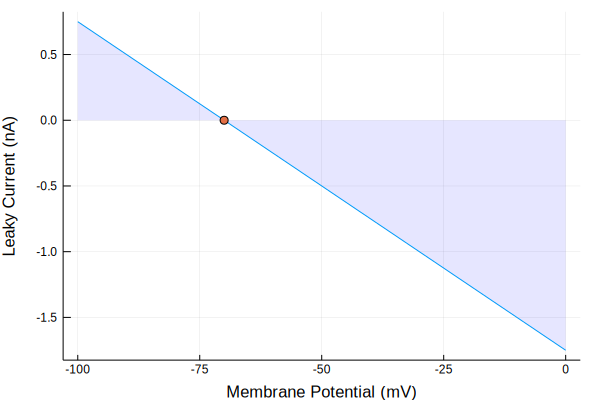

In [3]:
leaky_current(Vm) = -gL * (Vm - EL)
rts = find_zeros(leaky_current, -100.0, 0.0)  # 使用 Roots.jl中的 find_zeros來尋找方程式解  

plot(V, leaky_current.(V), fill = (0, 0.1, :Blue), leg=false)
scatter!(rts, zeros(length(rts)))

xlabel!("Membrane Potential (mV)")
ylabel!("Leaky Current (nA)")

### Na Current : $\color{Red}{- g_{NaP} \cdot m_{NaP}(V_{m}) \cdot (V_{m} - E_{Na})}$
這裡的鈉離子通道為電壓控制型(voltage-gated)，當膜電位去極化至一定程度，通道才會逐漸開啟。  
+ $m_{NaP}(V_{m})$ 是一個邏輯函數(sigmoid函數)，代表在越大的膜電位下，會有越高比例的鈉離子通道開啟，但最終趨於飽和。從定義公式的地方可得知，這裡設定了-45為反轉點，也就是說我們設定當膜電位在-45mV的時候，會有一半的鈉離子通道開啟。
+ $g_{NaP}$ 和$g_{L}$的意義相似，可以想像成有多少數量的鈉離子通道，在後續的範例中會看到這個參數十分重要。
+ $E_{Na}$ 是此鈉離子通道的反轉電位(reversal potential)，因為此通道只選擇性通透鈉離子，又膜內外鈉離子濃度不同，因此可根據Nernst equation計算出反轉電位，大於或小於反轉電位時，電流會有不同的流向。

讓我們先來看$m_{NaP}(V_{m})$的樣子，如同上述所言，鈉離子通道在膜電位較低時呈關閉狀態，膜電位提高時才逐漸開啟。

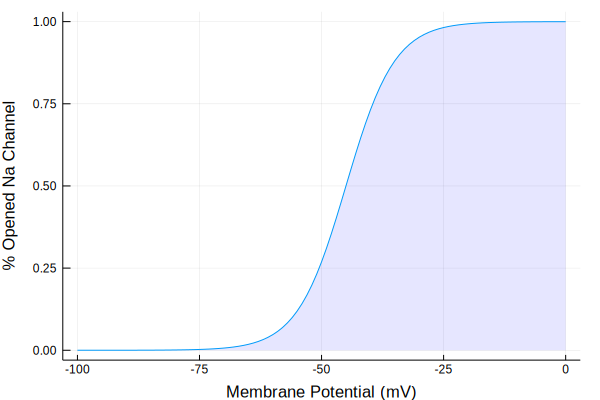

In [4]:
plot(V, mNaP.(V), fill = (0, 0.1, :Blue), leg=false)

xlabel!("Membrane Potential (mV)")
ylabel!("% Opened Na Channel")

接下來看看單純只有鈉離子造成的電流，這邊因為特別來查看反轉電位，因此將觀察的電位範圍擴大成 -100 ~ 80。從圖可見，鈉離子由膜外向內流(正電流)，且由於受到$m_{NaP}(V_{m})$的調控，使得膜電位相當低的時候，幾乎不會有電流產生。

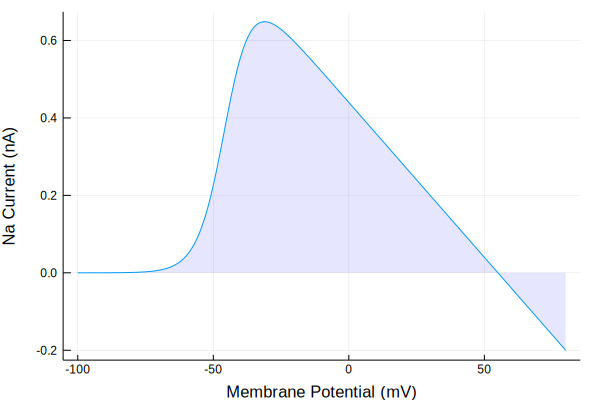

In [5]:
gNaP = 0.008
Na_current(Vm) = -gNaP * mNaP(Vm) * (Vm - ENa)

V_range = -100:1:80

plot(V_range, Na_current.(V_range), fill = (0, 0.1, :Blue), leg=false)

xlabel!("Membrane Potential (mV)")
ylabel!("Na Current (nA)")

最後我們加總leaky current和Na current，並使用3種不同的$g_{NaP}$值，來觀察在不同膜電位下，總電流流動的情形為何。  
+ $g_{NaP}=0$，圖形是一條斜直線，如同先前所描述。
+ $g_{NaP}=0.008$，有了Na current的貢獻，圖形開始變成曲線，但是目前仍然只有一個平衡點。  
+ $g_{NaP}=0.016$，隨著$g_{NaP}$逐漸增大，交於零的點從原來的1個變為3個，若剛好位在這三種膜電位上，leaky current和Na current會取得動態平衡，也就是此時的淨電流為零。

**整個系統可看作leaky current和Na current間的拔河，我們討論當$g_{NaP}=0.016$的情況，此時系統多了兩個淨電流為零的點。**  
+ **中間的點，若膜電位大於這個點一些些，以Na current的正電流為主，使得膜電位越變越大，最後偏離這個點；同樣地，若膜電位小於這個點一些些，反而是leaky current的負電流影響較大，最後狀態也會偏離這個點，因此這個點屬於不穩定點。**  
+ **右邊的點，類似於上述提過的靜止電位，同樣也是一個attractor，只不過在這裡主要是因為鈉離子通道的反轉電位而導致。**

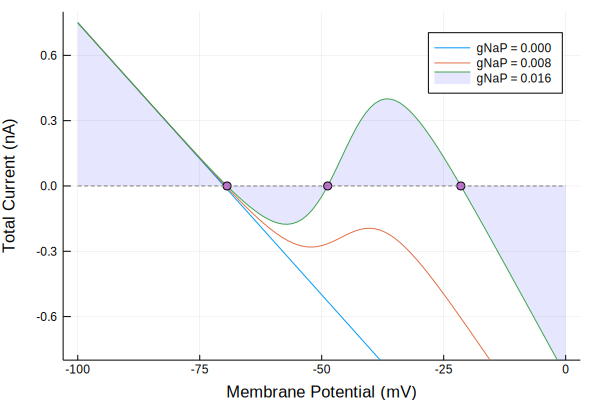

In [6]:
gNaP = 0.0
plot(V, dV.(V), label="gNaP = 0.000")

gNaP = 0.008
plot!(V, dV.(V), label="gNaP = 0.008")

gNaP = 0.016
plot!(V, dV.(V), fill = (0, 0.1, :Blue), label="gNaP = 0.016")
rts = find_zeros(dV, -100.0, 0.0)
scatter!(rts, zeros(length(rts)), label="")

plot!(V, zeros(length(V)), ylim=(-0.8, 0.8), linestyle=:dash, color=:Gray, label="")

xlabel!("Membrane Potential (mV)")
ylabel!("Total Current (nA)")

**藉由一次微分 $\frac{d(\frac{dV_m}{dt})}{dt}$，我們可以更容易判斷在平衡點時的穩定性，若斜率小於0，代表這個點為穩定點，反之，若斜率大於0，代表這個點為不穩定點。原因可由上圖看出，不再贅述。**  
(下面這段程式將三個平衡點帶入，計算$\frac{dV_{m}}{dt}一次微分後的值$，若結果為穩定點(斜率<0)輸出true，不穩定點則輸出false。)

In [7]:
gNaP = 0.016
rts = find_zeros(dV, -100.0, 0.0)
[slope<0 ? true : false for slope in dV'.(rts)]  # 透過 Calculus.jl，簡單使用 f'(x)來計算 f(x)微分後的結果。

3-element Array{Bool,1}:
  true
 false
  true

另外，除了透過上述找零點的方式，我們可以藉由另一種圖形energy landscape來更直觀的了解膜電位變化的情況。  
先複習一下前面定義過的公式 (注意：如同程式中定義的，$I_{app}=0$故省略，$C_{m}$也為求簡化而省略)，並且設$F(V_{m}) = \frac{dV_{m}}{dt}$，再積分$-F(V_{m})$即可得到energy landscape$U(V_{m})$。
$$F(V_{m}) = \frac{dV_{m}}{dt} = \color{blue}{-g_{L}(V_{m} - E_{L})} \color{Red}{- g_{NaP} \cdot m_{NaP}(V_{m}) \cdot (V_{m} - E_{Na})}$$
$$U(V_{m}) = \int\!-F(V_{m})\,dV_{m}$$

**Energy landscape非常直觀，可從圖中看到三個淨電流為零的點，分別對應到山峰和低谷。  
對應到山峰的點為不穩定點，只要有一些噪音(noise)存在，膜電位就會變大或變小，離開這個平衡點。  
對應到低谷的點即為穩定點，當處在穩定點的附近，即使有一些小擾動，最終仍然會回到這個穩定點，充分體現了attractor的意義。**

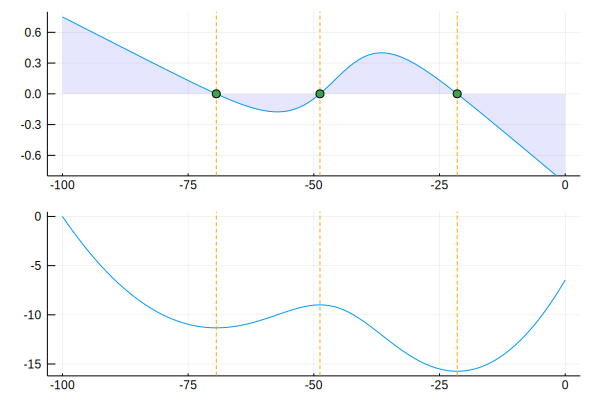

In [8]:
gNaP = 0.016
rts = find_zeros(dV, -100.0, 0.0)

p1 = begin
    plot(V, dV.(V), fill = (0, 0.1, :Blue), leg=false, ylim=(-0.8, 0.8))
    plot!(rts, seriestype=:vline, linestyle=:dash, color=:orange)
    scatter!(rts, zeros(length(rts)))
end

p2 = begin
    plot(V, -first.(quadgk.(dV, V[1], V)), leg=false)  # 透過 QuadGk.jl中的 quadgk進行數值積分。
    plot!(rts, seriestype=:vline, linestyle=:dash, color=:orange)
end

mylayout = @layout([a; b])
plot(p1, p2, layout=mylayout)

# Reference
Wang, X. J. (2010). Attractor Network Models. In _Encyclopedia of Neuroscience_ (pp. 667–679). Elsevier. https://doi.org/10.1016/B978-008045046-9.01397-8